# Adhesin Classification

In [26]:
import numpy as np
import tensorflow
from tensorflow import keras
import matplotlib.pyplot as plt
from Bio import SeqIO

np.random.seed(990)

## Compute features from sequences using iFeature

In [27]:
'''
# put the right path
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution

print("pos: DONE!")

!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type DPC --out dpc_cleaned_neg.out    # dipeptide composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDC --out ctdc_cleaned_neg.out  # composition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDT --out ctdt_cleaned_neg.out  # transition
!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type CTDD --out ctdd_cleaned_neg.out  # distribution

print("neg: DONE!")
'''

'\n# put the right path\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type AAC --out aac_cleaned_pos.out    # amino acids composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type DPC --out dpc_cleaned_pos.out    # dipeptide composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDC --out ctdc_cleaned_pos.out  # composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDT --out ctdt_cleaned_pos.out  # transition\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/positive/adhesins.fasta --type CTDD --out ctdd_cleaned_pos.out  # distribution\n\nprint("pos: DONE!")\n\n!python iFeature/iFeature.py --file ./spaan/data/25_similarity/negative/non_adhesins.fasta --type AAC --out aac_cleaned_neg.out    # amino acids composition\n!python iFeature/iFeature.py --file ./spaan/data/25_similari

In [28]:
def from_files_to_vectors(fasta_path, positive=True):
    if positive:
        proteins = list(SeqIO.parse(fasta_path+'adhesins.fasta', "fasta"))
    else:
        proteins = list(SeqIO.parse(fasta_path+'non_adhesins.fasta', "fasta"))
    extension = ".out"
    files = ["aac", "dpc", "ctdc", "ctdt", "ctdd"]
    if positive:
        names = "_pos"
    else:
        names = "_neg"
    for i in range(len(files)):
        files[i] += names
    datasets = [[] for el in files]
    for i in range(len(files)):
        with open(fasta_path+files[i]+extension) as f:
            lines = f.readlines()[1:]
            check_prot = 0
            for line in lines:
                information = line.split('\t')
                if not information[0] == proteins[check_prot].id:
                    print("Error in protein order! Return")
                    return datasets
                datasets[i].append(np.array([float(el) for el in information[1:]]))
                check_prot += 1
        datasets[i] = np.array(datasets[i])
    return datasets

In [29]:
# put the right path
pos_datasets = from_files_to_vectors("./spaan/data/25_similarity/positive/", positive=True)
neg_datasets = from_files_to_vectors("./spaan/data/25_similarity/negative/", positive=False)

In [30]:
y_pos = np.ones(pos_datasets[0].shape[0])
y_neg = np.zeros(neg_datasets[0].shape[0])

In [31]:
# attach datasets in order to obtain a matrix of (n, 20+400+39+39+195) features

# keep in mind the number of adhesins and the number of not adhesins
rows = 0
n_pos = y_pos.shape[0]
n_neg = y_neg.shape[0]
rows = n_pos + n_neg
print('Adhesins:', n_pos)
print('NON Adhesins:', n_neg)

# feature vectors dimensions
columns = 0
for i in range(len(pos_datasets)):
    tmp_dim = pos_datasets[i].shape[1]
    print(i+1, '-th feature dim:', tmp_dim)
    columns += tmp_dim

# data matrix to process
X = np.zeros((rows, columns))
print('Data matrix dimension:', X.shape)
for i in range(n_pos):
    X[i] = np.concatenate([pos_datasets[j][i] for j in range(5)])
for i in range(n_neg):
    X[n_pos+i] = np.concatenate([neg_datasets[j][i] for j in range(5)])

Adhesins: 3140
NON Adhesins: 3710
1 -th feature dim: 20
2 -th feature dim: 400
3 -th feature dim: 39
4 -th feature dim: 39
5 -th feature dim: 195
Data matrix dimension: (6850, 693)


In [32]:
# permutation
y = np.concatenate((y_pos, y_neg), axis=0)
c = np.random.permutation(np.arange(y.shape[0]))
y = y[c]
X = X[c] 

In [33]:
# we should remove outliers

In [34]:
# remember: standardization or scaling AFTER train-test split, otherwise there's data leakage!!!
X_train = X[:int(X.shape[0]*.5)]
X_val = X[int(X.shape[0]*.5):int(X.shape[0]*.75)]
X_test = X[int(X.shape[0]*.75):]

y_train = y[:int(y.shape[0]*.5)]
y_val = y[int(y.shape[0]*.5):int(y.shape[0]*.75)]
y_test = y[int(y.shape[0]*.75):]

print('Training data shape:', X_train.shape, y_train.shape)
print('Validation data shape:', X_val.shape, y_val.shape)
print('Test data shape:', X_test.shape, y_test.shape)

print('\nTraining adhesins and not-adhesins:', int(sum(y_train)), int(y_train.shape[0]-sum(y_train)))
print('Validation adhesins and not-adhesins:', int(sum(y_val)), int(y_val.shape[0]-sum(y_val)))
print('Test adhesins and not-adhesins:', int(sum(y_test)), int(y_test.shape[0]-sum(y_test)))

Training data shape: (3425, 693) (3425,)
Validation data shape: (1712, 693) (1712,)
Test data shape: (1713, 693) (1713,)

Training adhesins and not-adhesins: 1598 1827
Validation adhesins and not-adhesins: 746 966
Test adhesins and not-adhesins: 796 917


## PCA

In [35]:
# standardize data
# remember that test and validation data have to be standardized with training mean and std dev
# https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i

# print some column vectors to check
print('Before standardization:')
print('mean of the first column:', np.mean(X_train[:,0]))
print('mean of the second column:', np.mean(X_train[:,1]))
print('mean of the 451-th column:', np.mean(X_train[:,450]))

stdX = np.zeros(X_train.shape)
stdX_val = np.zeros(X_val.shape)
stdX_test = np.zeros(X_test.shape)

means = np.zeros(X_train.shape[1])
std_devs = np.zeros(X_train.shape[1])

for j in range(X_train.shape[1]):
    column = X_train[:,j]
    means[j] = np.mean(column)
    std_devs[j] = np.std(column)

    stdX[:,j] = (column - means[j]) / std_devs[j]
    stdX_val[:,j] = (X_val[:,j] - means[j]) / std_devs[j]
    stdX_test[:,j] = (X_test[:,j] - means[j]) / std_devs[j]

print('After standardization:')
print('mean of the first column:', np.mean(stdX[:,0]))
print('mean of the second column:', np.mean(stdX[:,1]))
print('mean of the 451-th column:', np.mean(stdX[:,450]))

np.save('mean', means)
np.save('std', std_devs)

Before standardization:
mean of the first column: 0.08563613920628796
mean of the second column: 0.01013786208206454
mean of the 451-th column: 0.10030911713991403
After standardization:
mean of the first column: -2.323526610368795e-16
mean of the second column: 2.4894927968237086e-17
mean of the 451-th column: -2.2301706304879057e-17


In [36]:
covariance_matrix = np.cov(stdX.T)

In [37]:
# The covariance matrix is symmetric, and thus has real eigenvalues. You may see a small imaginary part in some eigenvalues due to numerical error. The imaginary parts can generally be ignored.
# source: https://stackoverflow.com/questions/10420648/complex-eigen-values-in-pca-calculation

eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
eigen_values = np.real(eigen_values)
eigen_vectors = np.real(eigen_vectors)

In [38]:
# Calculating the explained variance on each of components

variance_explained = []
for i in eigen_values:
    variance_explained.append((i/sum(eigen_values))*100)

print(variance_explained)

[7.207969857539394, 5.5591769744244806, 4.286083603075206, 3.5416290897356575, 3.204703807259368, 2.680337544081207, 1.7964853033258164, 1.4997106024529692, 1.4110630244277302, 1.3036943558780987, 1.0134836456401877, 0.977479426487575, 0.9326483953881307, 0.8928300748233355, 0.8672363969461041, 0.8210607342432378, 0.7871422477345418, 0.7549063312592033, 0.7150979170848257, 0.6748852641096867, 0.6523842516591135, 0.6182417664133572, 0.5914909559902239, 0.5801294023122471, 0.5624955087183882, 0.5363471826353415, 0.5294615847600248, 0.5124485775386113, 0.4956969666016103, 0.489857757367391, 0.45952004788286, 0.45329659755378776, 0.43772413915602837, 0.4267608673152629, 0.41354049226873046, 0.4102864316174985, 0.3924903741738815, 0.38073317340492757, 0.3583497581548481, 0.35517502374073906, 0.35089929928078256, 0.34192103744076835, 0.33755357317145684, 0.32739260138745546, 0.3216299379017567, 0.32042717239749086, 0.30987049937721767, 0.30622327510689795, 0.3021187737631595, 0.2991374393503

In [39]:
cumulative_variance_explained = np.cumsum(variance_explained)

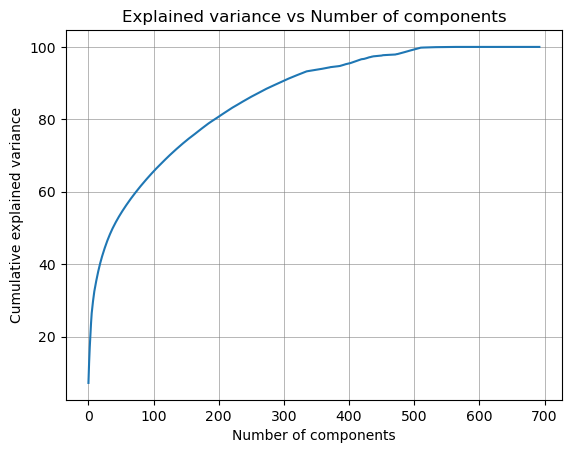

In [40]:
plt.title("Explained variance vs Number of components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(len(cumulative_variance_explained)), cumulative_variance_explained)

plt.show()
#plt.savefig('Explained variance.png')

In [41]:
K = 400
print('Principal components:', K)
print('Discarded components:', columns-K)

Principal components: 400
Discarded components: 293


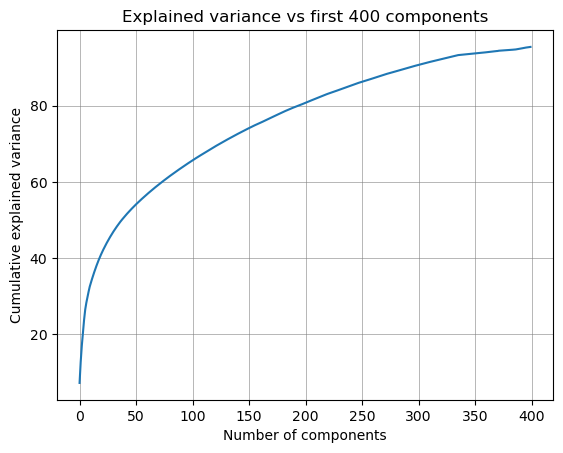

In [42]:
plt.title("Explained variance vs first " + str(K) + " components")

plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(color='gray', linewidth=.4)

plt.plot(range(K), cumulative_variance_explained[:K])

plt.show()
#plt.savefig('Explained variance.png')

In [43]:
# Project using first K components

projection_matrix = np.real((eigen_vectors.T[:][:K]).T)
print(projection_matrix.shape)

np.save('projection_matrix', projection_matrix)

(693, 400)


In [44]:
# project matrices
X_train = stdX.dot(projection_matrix)
X_val = stdX_val.dot(projection_matrix)
X_test = stdX_test.dot(projection_matrix)

In [45]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)
X.shape


(6850, 400)

## Neural Network

In [51]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Definisci la classe della rete neurale
class NeuralNetwork:
    def __init__(self):
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Dense(units=10, activation='sigmoid', input_shape=(K,)),
            Dense(units=1, activation='sigmoid')
        ])
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'recall', 'precision'])
        return model

# Definisci il numero di fold per la cross-validation
n_splits = 3
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Inizializza una lista per salvare gli score di validazione per ogni fold
val_accuracy_cv = []
val_recall_cv = []
val_precision_cv = []

# Itera attraverso i fold della cross-validation
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]
    
    # Inizializza e addestra la rete neurale
    nn = NeuralNetwork()
    history = nn.model.fit(
        x=X_train_fold, 
        y=y_train_fold,
        batch_size=64,
        epochs=1000,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[EarlyStopping(restore_best_weights=True, patience=20)]
    )
    
    # Valuta la rete neurale sul fold di validazione
    val_loss, val_accuracy, val_mse, val_recall, val_precision = nn.model.evaluate(X_val_fold, y_val_fold)
    val_accuracy_cv.append(val_accuracy)
    val_recall_cv.append(val_recall)
    val_precision_cv.append(val_precision)

# Calcola e stampa l'accuracy media dei fold di validazione
mean_val_accuracy = np.mean(val_accuracy_cv)
mean_val_recall = np.mean(val_recall_cv)
mean_val_precision = np.mean(val_precision_cv)
print("Mean Validation Accuracy:", mean_val_accuracy)
print("Mean Validation recall:", mean_val_recall)
print("Mean Validation precision:", mean_val_precision)

print("accuracy:", val_accuracy_cv)
print("recall:", val_recall_cv)
print("precision:", val_precision_cv)

Epoch 1/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6744 - loss: 0.6329 - mse: 0.2208 - precision: 0.6869 - recall: 0.5229 - val_accuracy: 0.8577 - val_loss: 0.5072 - val_mse: 0.1613 - val_precision: 0.8911 - val_recall: 0.7938
Epoch 2/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.8881 - loss: 0.4649 - mse: 0.1425 - precision: 0.9025 - recall: 0.8402 - val_accuracy: 0.9019 - val_loss: 0.3890 - val_mse: 0.1115 - val_precision: 0.9173 - val_recall: 0.8694
Epoch 3/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - accuracy: 0.9199 - loss: 0.3538 - mse: 0.0975 - precision: 0.9262 - recall: 0.8882 - val_accuracy: 0.9155 - val_loss: 0.3155 - val_mse: 0.0852 - val_precision: 0.9206 - val_recall: 0.8974
Epoch 4/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - accuracy: 0.9280 - loss: 0.2909 - mse: 0.0762 - precision: 0.9322 - recall: 0.9100 - val_accuracy: 0.9256 - val_loss: 0.2708 - val_mse: 0.0714 - val_precision: 0.9215 - val_recall: 0.9198
Epoch 5/1000
72/72 ━━━━━━━

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.9740 - loss: 0.0840 - mse: 0.0210 - precision: 0.9773 - recall: 0.9662 - val_accuracy: 0.9264 - val_loss: 0.2130 - val_mse: 0.0585 - val_precision: 0.9147 - val_recall: 0.9300
Epoch 31/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - accuracy: 0.9754 - loss: 0.0759 - mse: 0.0191 - precision: 0.9746 - recall: 0.9713 - val_accuracy: 0.9273 - val_loss: 0.2148 - val_mse: 0.0587 - val_precision: 0.9148 - val_recall: 0.9319
Epoch 32/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.9741 - loss: 0.0743 - mse: 0.0189 - precision: 0.9740 - recall: 0.9699 - val_accuracy: 0.9269 - val_loss: 0.2158 - val_mse: 0.0588 - val_precision: 0.9140 - val_recall: 0.9319
Epoch 33/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.9707 - loss: 0.0872 - mse: 0.0226 - precision: 0.9749 - recall: 0.9597 - val_accuracy: 0.9273 - val_loss: 0.2172 - val_mse: 0.0589 - val_precision: 0.9164 - val_recall: 0.9300
Epoch 34/1000
72/72 ━━━━━━━━━━━━━━

Epoch 25/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.9702 - loss: 0.0988 - mse: 0.0247 - precision: 0.9647 - recall: 0.9700 - val_accuracy: 0.9251 - val_loss: 0.2169 - val_mse: 0.0592 - val_precision: 0.9101 - val_recall: 0.9284
Epoch 26/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.9724 - loss: 0.0916 - mse: 0.0230 - precision: 0.9698 - recall: 0.9701 - val_accuracy: 0.9238 - val_loss: 0.2174 - val_mse: 0.0591 - val_precision: 0.9083 - val_recall: 0.9274
Epoch 27/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.9690 - loss: 0.0974 - mse: 0.0248 - precision: 0.9656 - recall: 0.9669 - val_accuracy: 0.9229 - val_loss: 0.2185 - val_mse: 0.0593 - val_precision: 0.9089 - val_recall: 0.9245
Epoch 28/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.9769 - loss: 0.0828 - mse: 0.0199 - precision: 0.9713 - recall: 0.9778 - val_accuracy: 0.9260 - val_loss: 0.2195 - val_mse: 0.0594 - val_precision: 0.9118 - val_recall: 0.9284
Epoch 29/1000
72/72 

Epoch 19/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - accuracy: 0.9628 - loss: 0.1144 - mse: 0.0295 - precision: 0.9595 - recall: 0.9619 - val_accuracy: 0.9295 - val_loss: 0.1884 - val_mse: 0.0529 - val_precision: 0.9151 - val_recall: 0.9285
Epoch 20/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - accuracy: 0.9656 - loss: 0.1040 - mse: 0.0268 - precision: 0.9636 - recall: 0.9611 - val_accuracy: 0.9264 - val_loss: 0.1889 - val_mse: 0.0530 - val_precision: 0.9097 - val_recall: 0.9275
Epoch 21/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - accuracy: 0.9672 - loss: 0.1073 - mse: 0.0273 - precision: 0.9680 - recall: 0.9615 - val_accuracy: 0.9290 - val_loss: 0.1888 - val_mse: 0.0531 - val_precision: 0.9110 - val_recall: 0.9324
Epoch 22/1000
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - accuracy: 0.9604 - loss: 0.1116 - mse: 0.0297 - precision: 0.9631 - recall: 0.9515 - val_accuracy: 0.9299 - val_loss: 0.1883 - val_mse: 0.0529 - val_precision: 0.9143 - val_recall: 0.9305
Epoch 23/1000
72/72 

In [141]:
from tensorflow.keras import regularizers

class neural_network:
    def __init__(self):
        input = tensorflow.keras.Input(shape=(K,))
        
        dense = tensorflow.keras.layers.Dense(units=10, 
                                                activation='sigmoid',
                                                kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3),
                                                bias_regularizer=regularizers.L2(1e-3),
                                                activity_regularizer=regularizers.L2(1e-3))(input)
        #norm = tensorflow.keras.layers.BatchNormalization()(dense)
        #drop = tensorflow.keras.layers.Dropout(.1)(dense)
        #dense = tensorflow.keras.layers.Dense(10, activation='sigmoid')(drop)
        output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(dense)

        model = tensorflow.keras.models.Model(inputs=input, outputs=output)
        model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics='accuracy')
        self.model = model

In [142]:
nn = neural_network()

In [143]:
nn.model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 400)]             0         
                                                                 
 dense_14 (Dense)            (None, 10)                4010      
                                                                 
 dense_15 (Dense)            (None, 1)                 11        
                                                                 
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________


In [144]:
history = nn.model.fit(
    x=X_train, 
    y=y_train,
    batch_size=64,
    epochs=1000,
    verbose=1,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[tensorflow.keras.callbacks.EarlyStopping(
    restore_best_weights=True,
    patience=10
        )]
)

Epoch 1/1000
58/58 [==============================] - 1s 6ms/step - loss: 0.9477 - accuracy: 0.5318 - val_loss: 0.8803 - val_accuracy: 0.6509
Epoch 2/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.8190 - accuracy: 0.7400 - val_loss: 0.7641 - val_accuracy: 0.8033
Epoch 3/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.7086 - accuracy: 0.8451 - val_loss: 0.6632 - val_accuracy: 0.8642
Epoch 4/1000
58/58 [==============================] - 0s 4ms/step - loss: 0.6139 - accuracy: 0.8898 - val_loss: 0.5780 - val_accuracy: 0.8912
Epoch 5/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.5348 - accuracy: 0.9076 - val_loss: 0.5070 - val_accuracy: 0.9041
Epoch 6/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.4713 - accuracy: 0.9162 - val_loss: 0.4512 - val_accuracy: 0.9138
Epoch 7/1000
58/58 [==============================] - 0s 3ms/step - loss: 0.4221 - accuracy: 0.9238 - val_loss: 0.4080 - val_accuracy: 0.9170
Epoch 

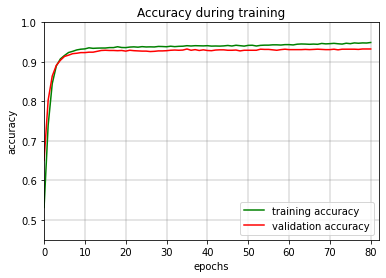

In [145]:
plt.title('Accuracy during training')
plt.plot(range(len(history.history['loss'])), history.history['accuracy'], label='training accuracy', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_accuracy'], label='validation accuracy', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="lower right")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0, len(history.history['loss'])+1)
plt.ylim(.45, 1.)
plt.savefig('acc.png')

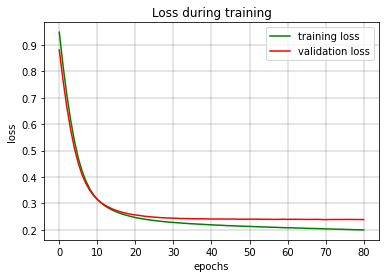

In [146]:
plt.title('Loss during training')
plt.plot(range(len(history.history['loss'])), history.history['loss'], label='training loss', color='green')
plt.plot(range(len(history.history['loss'])), history.history['val_loss'], label='validation loss', color='red')
plt.grid(color='gray', linewidth=.4)

plt.legend(loc="upper right")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('loss.png')

In [147]:
nn.model.evaluate(x=X_test, y=y_test)

58/58 [==============================] - 0s 2ms/step - loss: 0.2290 - accuracy: 0.9391


[0.22902756929397583, 0.939116358757019]

In [148]:
nn.model.save('ac.h5')

In [ ]:
# I think we can obtain the same results without using a nn